In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
import warnings
import pickle
# from sklearn.metrics import classification_report
# from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, balanced_accuracy_score
# from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
# import timeit

import microscope as mc
import data_organizer as do



sns.set_style("white")
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
base_d = "/Users/erankotler/dinamo"
data_d = os.path.join(base_d, "data/gse_data_20231002")

results_d = os.path.join(base_d, "resutls")
models_d = os.path.join(base_d, "models")


In [3]:
[d for d in os.listdir(data_d) if d.startswith("GSE")]

['GSE145361',
 'GSE111223',
 'GSE190348',
 'GSE42861',
 'GSE111942',
 'GSE87095',
 'GSE147221',
 'GSE175364',
 'GSE111629',
 'GSE121192']

In [5]:
gse_acc = "GSE111223"
gse_d = os.path.join(data_d, gse_acc)
data = do.Dataset(gse_d=gse_d)
# data.load_data() 
data.load_data(max_CpGs=500, max_samps=20) # For debugging
data.organize_data()

# Examine original label names
print("Original labels:", data.orig_label_names)
print("Number of samples:", data.df.shape[0])

cv_res = mc.cv_train_test(
    data, 
    CV = 10, # "LOO" # 10 #"LOO"
    penalty = 'l1', 
    internalCV_folds = 5,
    nan_policy="impute_by_median",
    feat_selection='wilcox',
    feat_selection_pval_thresh=0.05)

Target label counts (0/1): 10 / 10
Original labels: ['case' 'control']
Number of samples: 20
Starting cross validation
Starting fold 0 - Train-test splitting
CV fold 0 Train size: 18, test size: 2 (fract positives in train: 0.444)
Imputing missing values, elapsed time: 0.0 sec
Starting feature selection, elapsed time: 0.0 sec
Selecting features using wilcoxon
Retained 8 features
Feature selection complete, ready for training, elapsed time: 0.0 sec
Fold complete, fold time: 1.2 sec
Starting fold 1 - Train-test splitting
CV fold 1 Train size: 18, test size: 2 (fract positives in train: 0.556)
Imputing missing values, elapsed time: 0.0 sec
Starting feature selection, elapsed time: 0.0 sec
Selecting features using wilcoxon
Retained 23 features
Feature selection complete, ready for training, elapsed time: 0.0 sec
Fold complete, fold time: 0.5 sec
Starting fold 2 - Train-test splitting
CV fold 2 Train size: 18, test size: 2 (fract positives in train: 0.500)
Imputing missing values, elapsed t

In [5]:
RA_datasets = ["GSE42861","GSE111942","GSE121192","GSE87095"]

In [7]:
# gse_acc1,gse_acc2  = ["GSE42861","GSE111942"]#"GSE111223"
def get_data(gse_d):
    data = do.Dataset(gse_d=gse_d)
    data.load_data() 
    # data.load_data(max_CpGs=5000, max_samps=100) # For debugging
    data.organize_data()
    return(data)
    

datas = {}
for i, gse_acc in enumerate(RA_datasets):
    print("Getting data for", gse_acc)
    gse_d = os.path.join(data_d, gse_acc)
    datas[i] = get_data(gse_d)

Getting data for GSE42861
Target label counts (0/1): 335 / 354
Getting data for GSE111942
Target label counts (0/1): 18 / 25
Getting data for GSE121192
Target label counts (0/1): 16 / 30
Getting data for GSE87095
Target label counts (0/1): 73 / 49


In [8]:
# gse_d = os.path.join(data_d, "GSE121192")
# datas[2] = get_data(gse_d)

In [9]:
dataset1 = datas[1]
dataset2 = datas[2]


merged = do.merge_datasets(dataset1, dataset2, feature_merge="inner")

Target label counts (0/1): 34 / 55


In [243]:
cv_res = mc.cv_train_test(
    merged, 
    CV = 10, # "LOO" # 10 #"LOO"
    penalty = 'l1', 
    internalCV_folds = 5,
    nan_policy="impute_by_median",
    feat_selection='wilcox',
    feat_selection_pval_thresh=0.05)

Starting cross validation
Starting fold 0 - Train-test splitting
CV fold 0 Train size: 80, test size: 9 (fract positives in train: 0.613)
Imputing missing values, elapsed time: 0.2 sec
Starting feature selection, elapsed time: 1.2 sec
Selecting features using wilcoxon
Retained 44480 features
Feature selection complete, ready for training, elapsed time: 15.6 sec
Fold complete, fold time: 19.1 sec
Starting fold 1 - Train-test splitting
CV fold 1 Train size: 80, test size: 9 (fract positives in train: 0.625)
Imputing missing values, elapsed time: 0.3 sec
Starting feature selection, elapsed time: 1.4 sec
Selecting features using wilcoxon
Retained 36359 features
Feature selection complete, ready for training, elapsed time: 15.8 sec
Fold complete, fold time: 18.2 sec
Starting fold 2 - Train-test splitting
CV fold 2 Train size: 80, test size: 9 (fract positives in train: 0.613)
Imputing missing values, elapsed time: 0.1 sec
Starting feature selection, elapsed time: 1.2 sec
Selecting features 

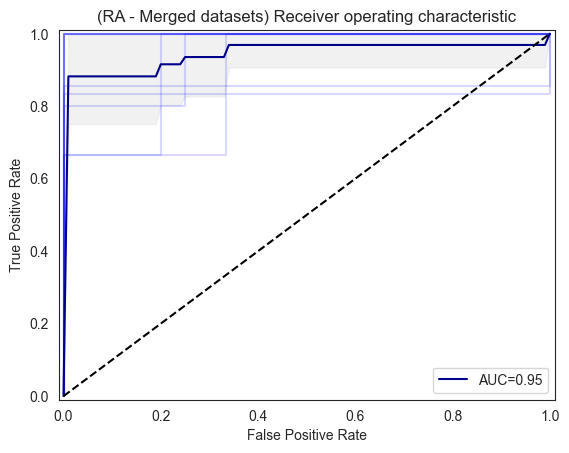

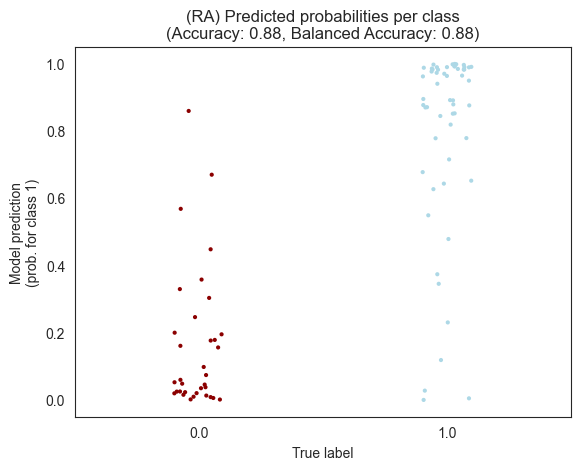

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85        34
         1.0       0.94      0.85      0.90        55

    accuracy                           0.88        89
   macro avg       0.87      0.88      0.87        89
weighted avg       0.88      0.88      0.88        89



In [244]:
mc.plot_cv_roc(cv_res, title_pfx="(RA - Merged datasets)")#, out_f=os.path.join(figs_d, cv_res["file_pfx"]+"_ROC.pdf"))
mc.plot_pred_prob_by_labels(cv_res, title_pfx="(RA)")#, out_f=os.path.join(figs_d, cv_res["file_pfx"]+"_class_pred_probs.pdf"))
mc.print_report(cv_res, THRESH=0.5)

In [252]:
%%time
train_dataset = merged # datas[2]
res1 = mc.train_on_entire_dataset(
    train_dataset,
    penalty = 'l2',
    scale_data = False,#True, #
    internalCV_folds = 5,
    nan_policy="impute_by_median",
    feat_selection="wilcox",
    feat_selection_pval_thresh=0.05,
    out_f=None)

Removing/imputing NaN feature values
Selecting features using wilcoxon
Retained 49722 features
Training model
Run time: 83.9 sec
CPU times: user 5min 13s, sys: 3min 57s, total: 9min 10s
Wall time: 1min 23s


In [253]:
res1["trained_model"].C_

array([2.7825594])

In [254]:
%%time
pred_data = datas[0]

y_pred, y_pred_prob = mc.predict_with_trained_model(
    pred_data=pred_data,
    model=res1["trained_model"], 
    model_features=res1["features_used"], 
    scaler=res1["scaler"], 
    imp_vals=res1["imputation_vals"]
)

y_true = pred_data.y

49722 features used for prediction
Imputing NaN feature values
CPU times: user 357 ms, sys: 669 ms, total: 1.03 s
Wall time: 187 ms


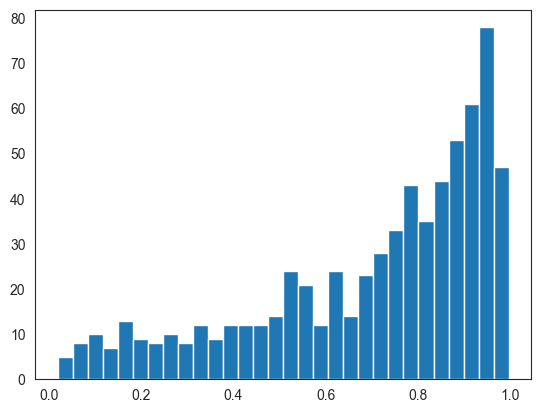

In [255]:
plt.hist(y_pred_prob, bins=30);#, range = [1-0.00001, 1]);

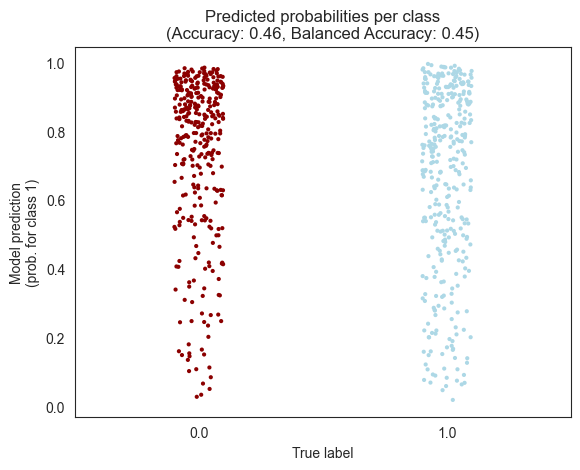

In [256]:
sns.stripplot(x=y_true, y=y_pred_prob, size=3, palette=["darkred","lightblue"])
plt.xlabel("True label")
plt.ylabel("Model prediction\n(prob. for class 1)")

score = accuracy_score(y_true, y_pred)
bal_score = balanced_accuracy_score(y_true, y_pred) # Defined as averaged recall for each class

plt.title('Predicted probabilities per class\n(Accuracy: %.2f, Balanced Accuracy: %.2f)'%(score, bal_score))

# if out_f is not None:
#     plt.savefig(out_f)        
plt.show()

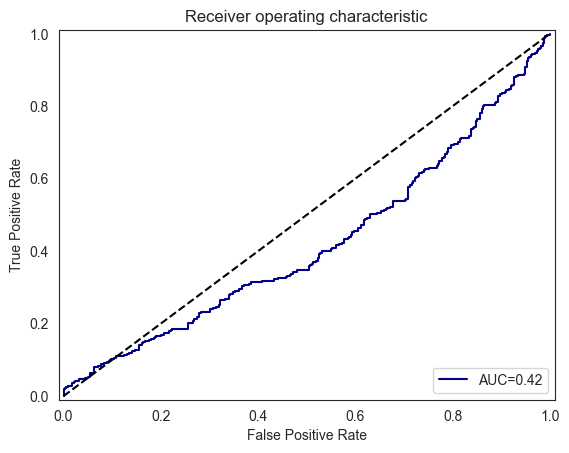

In [258]:
auc = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_true,  y_pred_prob)
plt.plot(fpr,tpr, c='darkblue', label="AUC=%0.2f"%auc)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# if out_f is not None:
#     plt.savefig(out_f)
plt.show()

In [21]:
dataset = merged

In [27]:
dataset.df.shape[0]

89

In [42]:
train_dfs, train_ys, df_test, y_test = mc.create_downsampled_train_sets(dataset, 
                                                                        rel_train_fracts = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1],
                                                                        test_frac=0.2)

In [43]:
auc_scores, acc_scores, train_sizes = {}, {}, {}

for frac in list(train_dfs.keys()):
    print("==== Starting Evaluating train set fraction of %.3f ===="%frac)
    auc_scores[frac], acc_scores[frac], train_sizes[frac] = mc.train_score(
        train_dfs[frac], df_test, train_ys[frac], y_test,
        penalty = 'l2', 
        internalCV_folds = 5,
        feat_selection="wilcox",
        feat_selection_pval_thresh=0.1,
        nan_policy="impute_by_median",
        min_train_size=20)
    

==== Starting Evaluating train set fraction of 0.100 ====
Train data size (7) is below defined 'min_train_size' -> skipping
==== Starting Evaluating train set fraction of 0.200 ====
Train data size (14) is below defined 'min_train_size' -> skipping
==== Starting Evaluating train set fraction of 0.400 ====
Evaluating model trained on 28 samples (test set size: 18 samples
Imputing missing values, elapsed time: 0.1 sec
Starting feature selection, elapsed time: 0.5 sec
Selecting features using wilcoxon
Retained 33424 features
Feature selection complete, starting training, elapsed time: 13.6 sec
==== Starting Evaluating train set fraction of 0.600 ====
Evaluating model trained on 42 samples (test set size: 18 samples
Imputing missing values, elapsed time: 0.1 sec
Starting feature selection, elapsed time: 0.6 sec
Selecting features using wilcoxon
Retained 34228 features
Feature selection complete, starting training, elapsed time: 12.3 sec
==== Starting Evaluating train set fraction of 0.800 

In [44]:
from model_performance_utils import *

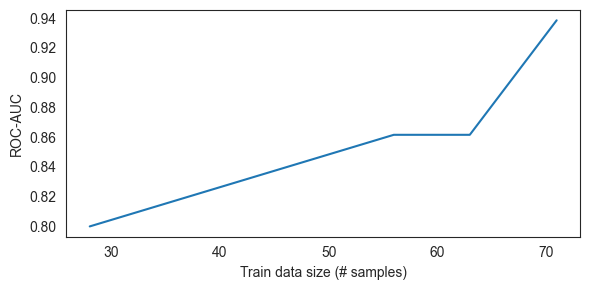

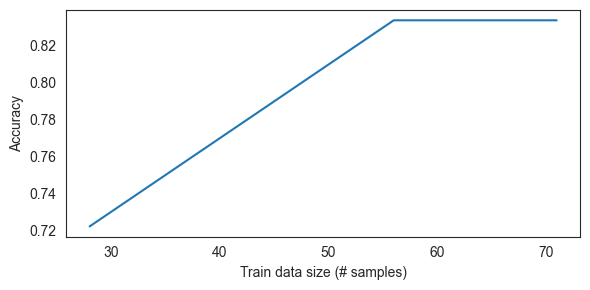

In [45]:
plot_performance_vs_data_size(train_sizes, auc_scores, score_name="ROC-AUC")
plot_performance_vs_data_size(train_sizes, acc_scores, score_name="Accuracy")

In [30]:
# data_sizes = [train_sizes[fract] for fract in list(train_sizes.keys())]
# scores = [auc_scores[fract] for fract in list(train_sizes.keys())]

In [37]:
# df = pd.DataFrame(data={
#     "num_samples": data_sizes, 
#     "score":scores},
#              index = list(train_sizes.keys())
#             )

# -- END OF NOTEBOOK ---

# TO DEL 

In [324]:
# def create_downsampled_train_sets(dataset, test_frac=0.2, rel_train_fracts=None, random_state=42):
#     """ Takes in Dataset object and sets aside a constant test-set for evaluation. Creates downampled train sets of variable size by given fractions.
#     dataset: a Dataset object
#     returns dicts with train-set dfs per each relative factions, and simple dataframes fro test (X and y dfs)
#     """
#     if rel_train_fracts is None:
#         rel_train_fracts = [0.2, 0.4, 0.6, 0.8, 1] # Default subsets
        
#     df = dataset.df
#     y = dataset.y

#     # Put aside fraction of data for test
#     df_train, df_test, y_train, y_test = train_test_split(dataset.df, dataset.y, test_size=test_frac, random_state=random_state)

#     # Create downsampled fraction of train set
#     train_dfs, train_ys = {}, {}
#     for frac in rel_train_fracts:
#         if frac<1:
#             train_dfs[frac], _, train_ys[frac], _ = train_test_split(df_train, y_train, test_size=1-frac, random_state=random_state)
#         else:
#             train_dfs[frac], train_ys[frac] = df_train, y_train

#     return(train_dfs, train_ys, df_test, y_test)

In [366]:
# def train_score(
#     df_train, df_test, y_train, y_test,
#     penalty = 'l1', 
#     internalCV_folds = 5,
#     feat_selection="wilcox",
#     feat_selection_pval_thresh=0.01,
#     nan_policy="impute_by_median",
#     min_train_size=20):

#     start = timeit.default_timer()
#     train_size, test_size = df_train.shape[0], df_test.shape[0]
#     if train_size < min_train_size:
#         print("Train data size (%i) is below defined 'min_train_size' -> skipping"%train_size)
#         return (np.nan,np.nan,np.nan)
#     else:
#         print("Evaluating model trained on %i samples (test set size: %i samples"%(train_size, test_size))

#     # remove features that are NaN in entire train set:  ###TODO- remove features above certain fraction of NaNs in train data
#     df_train = df_train.dropna(how="any", axis=1)
#     df_test = df_test.loc[:, df_train.columns]

#     if nan_policy is not None: # Impute missing values in train set
#         stop1 = timeit.default_timer()
#         print('Imputing missing values, elapsed time: %.1f sec'%(stop1 - start))
#         imp_vals = feature_imputation_values(df_train, nan_policy=nan_policy)
#         # Fill in missing values in train and in test sets by train set imputation values
#         df_train = pd.DataFrame(data=numba_fillna(df_train.values, imp_vals.values), index=df_train.index, columns=df_train.columns)
#         df_test = pd.DataFrame(data=numba_fillna(df_test.values, imp_vals.values), index=df_test.index, columns=df_test.columns)
        
#     print('Starting feature selection, elapsed time: %.1f sec'%(timeit.default_timer() - start))
    
#     # Feature selection (based on train set contrasting)
#     if feat_selection is not None:
#         feats_to_keep = select_features(df_train, y_train, by=feat_selection, pval_thresh=feat_selection_pval_thresh)
#     else:
#         feats_to_keep = list(df_train.columns)
        
#     print("Retained %i features"%len(feats_to_keep))
#     X_train = df_train.loc[:,feats_to_keep].values
#     X_test = df_test.loc[:, feats_to_keep].values    
    
#     print('Feature selection complete, starting training, elapsed time: %.1f sec'%(timeit.default_timer() - start))
#     _, _, y_pred, y_pred_prob = train_test(X_train, X_test, y_train, penalty=penalty, internalCV_folds=internalCV_folds)
    
#     # Evaluate performance on test set
#     auc_score = roc_auc_score(y_test, y_pred_prob)
#     acc_score = accuracy_score(y_test, y_pred)
#     return(auc_score, acc_score, train_size)


# def plot_performance_vs_data_size(train_sizes, scores, score_name="score", title=""):
#     data_sizes = [train_sizes[fract] for fract in list(train_sizes.keys())]
#     scores = [scores[fract] for fract in list(train_sizes.keys())]
#     f, ax = plt.subplots(1, figsize=(6,3))
#     ax.plot(data_sizes, scores)
#     ax.set_xlabel("Train data size (# samples)")
#     ax.set_ylabel(score_name)
#     ax.set_title("")
#     plt.tight_layout()
#     plt.show()

In [4]:
# gse_acc = "GSE111223" # PD ~260 samps
# gse_acc = "GSE111629" # PD ~570 samps
# gse_acc = "GSE145361" # PD, ~1800 samps

PD_datasets = ["GSE145361","GSE111629", "GSE190348", "GSE111223"]
RA_datasets = ["GSE42861","GSE111942","GSE121192","GSE87095"] # "GSE175364" is a 78-patient dataset for prediction of  undifferentiated arthritis (UA)=>RA progression with only 6 controls